# Training State of the art computer vision model

## Installs

Let's first install necessary libraries.

In [3]:
!pip install fastai --upgrade --q
!pip install nbdev --q

In [1]:
!nvidia-smi

Wed Dec  8 00:42:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   45C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting Started

Now, let's explore various techniques to train a state-of-the art computer vision model. For this purpose let's use the condensed short version of Imagenet data created by fastai team. 

Let's begin by downloading the data

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.IMAGENETTE)

In [4]:
(path).ls()

(#3) [Path('/home/studio-lab-user/.fastai/data/imagenette2/train'),Path('/home/studio-lab-user/.fastai/data/imagenette2/noisy_imagenette.csv'),Path('/home/studio-lab-user/.fastai/data/imagenette2/val')]

### Technique 1 - Presizing 

Let's create the dataloaders using the **presizing technique** i.e. first reszing the image to relativly larger size in item transforms and then resizing it back to samller size by randomly selecting some part of the image every time. This ensures data augmentation is done properly.

Let's create the datablock...

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

Now create dataloaders,

In [6]:
dls = dblock.dataloaders(path)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


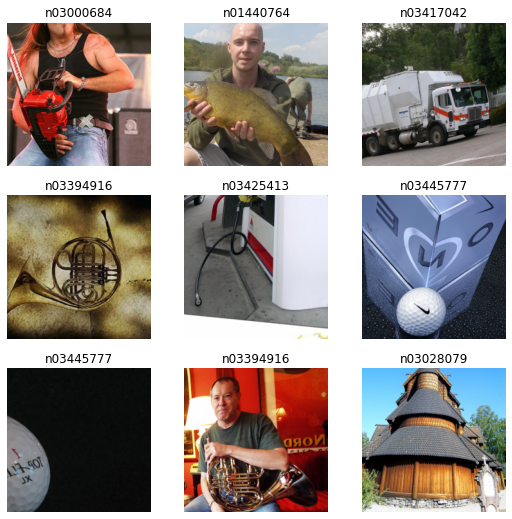

In [8]:
dls.show_batch()

In [10]:
x,y = dls.one_batch()
y

TensorCategory([2, 4, 5, 1, 2, 2, 9, 2, 2, 4, 7, 7, 4, 7, 3, 9, 8, 4, 1, 8, 0, 9, 7, 6,
        6, 5, 1, 7, 7, 3, 1, 5, 8, 2, 2, 2, 3, 2, 4, 3, 6, 1, 5, 7, 0, 9, 3, 2,
        2, 2, 6, 1, 6, 8, 6, 5, 0, 3, 7, 9, 6, 9, 6, 4], device='cuda:0')

In [12]:
y[0]

TensorCategory(2, device='cuda:0')

Now since our data is ready, we create a Learner object and train the model

In [16]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [17]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.686644,2.370378,0.378344,02:09
1,1.299073,1.387382,0.550318,02:12
2,1.017209,1.112507,0.633885,02:14
3,0.774054,0.763407,0.755159,02:14
4,0.626314,0.609499,0.810701,02:14


We were able to achieve accuracy of 81%... Which is not bad considering we have trained the model from scratch. Let's consider this model as our baseline and build upon it.

### Technique 2 - Normalization

Now let's another technique which we can use to imporve the model training. 

**Normalization** is the process where we normalize the training dat such that its mean will be 0 and standard deviation will be 1. 

In [19]:
x, y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.4632, 0.4571, 0.4232], device='cuda:0'),
 TensorImage([0.2850, 0.2780, 0.2936], device='cuda:0'))

We can see that it is not normalized. Now let's see how we can do the same in fastai

In [13]:
# Let's create a helper function to create dataloaders 
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       splitter=GrandparentSplitter(valid_name='val'),
                       item_tfms=Resize(460),
                       batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [21]:
dls = get_dls(64, 224)

In [22]:
x, y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.0114,  0.1286,  0.2529], device='cuda:0'),
 TensorImage([1.1864, 1.1724, 1.3257], device='cuda:0'))

Now we can see that it is almost closer to mean 0 and std 1. <br />
Now let's train the model and see how it effects the training 

In [23]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [24]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.677170,2.533046,0.396178,02:09
1,1.334751,1.464441,0.543185,02:13
2,1.002216,1.203541,0.624713,02:13
3,0.771552,0.819842,0.732994,02:13
4,0.623933,0.596722,0.815796,02:13


Some things to remeber: <br />

  * `Normalization` is important while using pretrained models, since preatrained models will only have the knowledge of data it is trained for i.e. normalized data. <br />
  * Hence it is always recommeded to always stick to the statistics that the model is trained for while pretraining. <br />
  * When we use `cnn_learner`, fastai will automatically add the proper Normalize transform <br />
  * Since we are training from scratch here, we need to add the normalization details manually<br />
  * If you do not pass any statistics to the `Normalize` transform, fastai will automatically calculate from a single batch of data<br />

### Technique 3 - Progressive Resizing

Technique: Start training small images and end training using large images. Spending most of the epochs training with small images helps training complete much faster. Completing training using large images makes the final accuracy much higher. This technique is called **Progressive Resizing**

This also is another form of data augmentation. Therefore we can get better generalization of our models that are trained with progressive resizing.

First, let's create dataloaders with small size and use `fit_one_cycle` in usual way.<br /> (For this let's use the `get_dls` function to create dls)

In [25]:
dls = get_dls(128, 128)

In [26]:
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [27]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.025208,2.183286,0.367389,01:11
1,1.443086,1.304393,0.587516,01:08
2,1.055835,0.883048,0.726115,01:09
3,0.840836,0.784624,0.757452,01:09


Now let's replace the dataloaders inside the Learner and fine tune it:

In [28]:
learn.dls = get_dls(64, 224)

In [29]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.884480,1.242807,0.653758,02:04


epoch,train_loss,valid_loss,accuracy,time
0,0.687859,1.135263,0.658344,02:08
1,0.726568,0.732747,0.763567,02:13
2,0.636346,0.706917,0.771720,02:13
3,0.541665,0.549933,0.824968,02:12
4,0.478650,0.521277,0.835669,02:12


In [ ]:
learn.dls = get_dls(32, 320)
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.859328,1.343785,0.602038,04:10


epoch,train_loss,valid_loss,accuracy,time
0,0.667171,0.891939,0.752866,04:06
1,0.607422,0.626567,0.809682,04:04
2,0.530447,0.510685,0.840764,04:06
3,0.416937,0.471303,0.850446,04:04


Some things to remember:

   * We can repeat the process of increasing size and training more epochs as many times as you like, but there is no benefit by using an image size larger than the size of your images on disk
   * This technique might not be useful for transfer learning where pretrained model was trained on task similar to transfer learning task and similar sized images. So in that case, weights need not be changed much and training on smaller images may damage the existing weights.
   * On other hand, if transfer learning task includes training on different size, shapes or styles than those used on pretrined task, progressive resizing might probably help.

We can see that training has resulted in better output metrics

### Technique 4 - Test Time Augmentation

Applying data augmentation on validation images and making predictions. Then take the average of the predictions.

**Test Time Augmentation** : During inference or validation, creating multiple versions of each image using data agmentation, and then taking the average or maximum of the predictions for each augmented version of the image

It does not change the time required for training, but will increase the amount of time required for validation or inference by the number of test-time augmented images requested. By default, fastai will use the unaugmented creter-crop image plus four randomly augmented images.

We can pass any dataloaders to **tta()** method

In [37]:
preds, targs = learn.tta()

In [38]:
accuracy(preds, targs).item()

0.8619108200073242

We can see that the accuracy is little more that what we got from training.

### Mixup

Mixup is a powerful data augmentation technique that can provid3 dramatically higher accuracy, especially when you don't have a pretrined model that was trained on dataset similar to your data

In [14]:
dls = get_dls(64, 224)

In [15]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp)

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.012071,2.349188,0.362038,02:18
1,1.692466,1.552932,0.489427,02:09
